In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

In [18]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


In [ ]:
# get the train set from drive
!cd /content/data/
! unzip /content/gdrive/MyDrive/av_cw/train.zip

In [ ]:
#these are just random not calculated
#need to be calculated
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [ ]:
#split the train data to train and validation sets
def train_val_dataset(dataset, val_split=0.25, augu=False):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)

#normalization
#return 3 * 224 * 224    
    datasets['train'].dataset.transform = transforms.Compose([
    	transforms.Resize(256),
      transforms.CenterCrop(224),
    	transforms.ToTensor(),
    	transforms.Normalize(mean, std)
            ])
            
    datasets['val'].dataset.transform = transforms.Compose([
 		
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
            ])
#adding augumentation data
    if augu:
      augu_data = data_augumentation(copy.deepcopy(datasets["train"]),vflip=True)
      datasets['train']+=augu_data
    return datasets



In [ ]:
#adding augumentation data function
def data_augumentation(image_datasets,hflip=False,vflip=False,r90c=False,r180c=False,r270c=False,blur=False):
  if vflip:
    image_datasets.dataset.transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.RandomVerticalFlip(p=1.0),
      transforms.ToTensor(),
    	transforms.Normalize(mean, std)
      ])
  if hflip:
    image_datasets.dataset.transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.RandomHorizontalFlip(p=1.0),
      transforms.ToTensor(),
    	transforms.Normalize(mean, std)
      ])
  if r90c:
    image_datasets.dataset.transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.RandomRotation(90),
      transforms.ToTensor(),
    	transforms.Normalize(mean, std)
      ])
  if r180c:
    image_datasets.dataset.transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.RandomRotation(180),
      transforms.ToTensor(),
    	transforms.Normalize(mean, std)
      ])
  if r270c:
    image_datasets.dataset.transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.RandomRotation(270),
      transforms.ToTensor(),
    	transforms.Normalize(mean, std)
      ])
  if blur:
    image_datasets.dataset.transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.GaussianBlur(kernel_size=224),
      transforms.ToTensor(),
    	transforms.Normalize(mean, std)
      ])
    

  return image_datasets


In [ ]:
#to show images
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [ ]:
#trains the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#loads the unzipped train folder from colab
image_path = '/content/train'
dataset = ImageFolder(image_path)

In [ ]:
#print the number of total images/train images/val images
print(len(dataset))
image_datasets = train_val_dataset(dataset,augu=True)
print(len(image_datasets['train']))
print(len(image_datasets['val']))

50000
75000
12500


In [ ]:
#fastest loader on colab with batch_size=64 and num_workers=2
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=2)
              for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

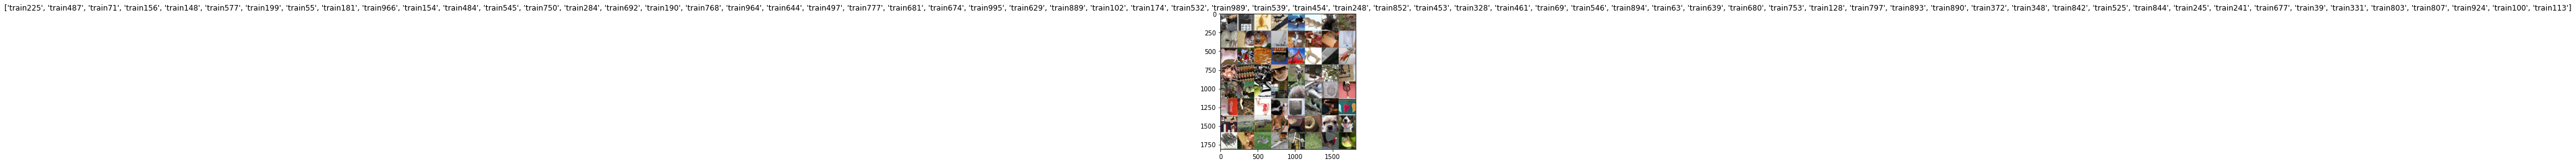

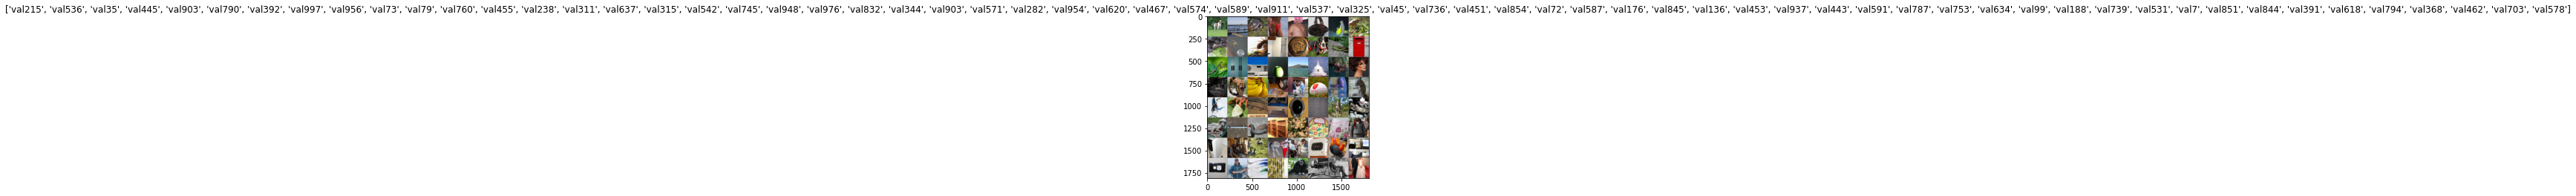

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=['train'+str(x.item()) for x in classes])

# Get a batch of validation data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=['val'+str(x.item()) for x in classes])

In [ ]:
#### Finetuning the convnet ####

#model = models.resnet50(pretrained=False)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#load checkpoint from google drive
FILE = "/content/gdrive/MyDrive/av_cw/resnet50_fconv_model_best.pth.tar"
checkpoint = torch.load(FILE)
print(checkpoint.keys())
model = nn.DataParallel(model)
model.load_state_dict(checkpoint['state_dict'])

#starts training
model = model.to(device)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=5)

#saves best model after training to drive
torch.save(model.state_dict(), FILE)